# Kaggle: Zillow Prize

In [39]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import Imputer
import missingno as msno
import re
from sklearn.base import TransformerMixin
%matplotlib inline

In [40]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

## Importing datasets

In [229]:
properties_path = 'https://s3.us-east-2.amazonaws.com/aws-emr-dedicated/data/zillow/properties_2016.csv'
train_path = 'https://s3.us-east-2.amazonaws.com/aws-emr-dedicated/data/zillow/train_2016_v2.csv'

properties = pd.read_csv(filepath_or_buffer=properties_path)
train = pd.read_csv(filepath_or_buffer=train_path)

/Applications/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [230]:
properties.set_index('parcelid', inplace=True)
properties['latitude'] = properties['latitude']/1e6
properties['longitude'] = properties['longitude']/1e6

In [231]:
properties_in_train_origin = properties.loc[train['parcelid'].drop_duplicates()]

In [286]:
properties_in_train = properties_in_train_origin.copy()
include_properties=False
tables = []
if include_properties:
    tables = [properties_in_train, properties]
else:
    tables = [properties_in_train]
print(properties.shape)
print(train.shape)
print(properties_in_train.shape)

(2985217, 57)
(90275, 3)
(90150, 57)


## Visualization of missing values

In [285]:
properties_in_train['numberofstories'].value_counts(dropna=False)

NaN     69610
 1.0    11997
 2.0     8034
 3.0      507
 4.0        2
Name: numberofstories, dtype: int64

In [284]:
# missing percentage
print(properties_in_train.shape)
properties_in_train.count().sort_values() / properties_in_train.shape[0]

(90150, 28)


hashottuborspa                  0.026212
numberofstories                 0.227842
airconditioningtypeid           0.318891
garagetotalsqft                 0.331636
regionidneighborhood            0.398846
heatingorsystemtypeid           0.621242
buildingqualitytypeid           0.635430
propertyzoningdesc              0.645946
lotsizesquarefeet               0.887565
regionidcity                    0.980022
yearbuilt                       0.991647
calculatedfinishedsquarefeet    0.992701
regionidzip                     0.999612
taxamount                       0.999933
propertycountylandusecode       0.999989
taxvaluedollarcnt               0.999989
taxdelinquencyflag              1.000000
bathroomcnt                     1.000000
unitcnt                         1.000000
longitude                       1.000000
latitude                        1.000000
regionidcounty                  1.000000
rawcensustractandblock          1.000000
yardbuildingsqft                1.000000
propertylanduset

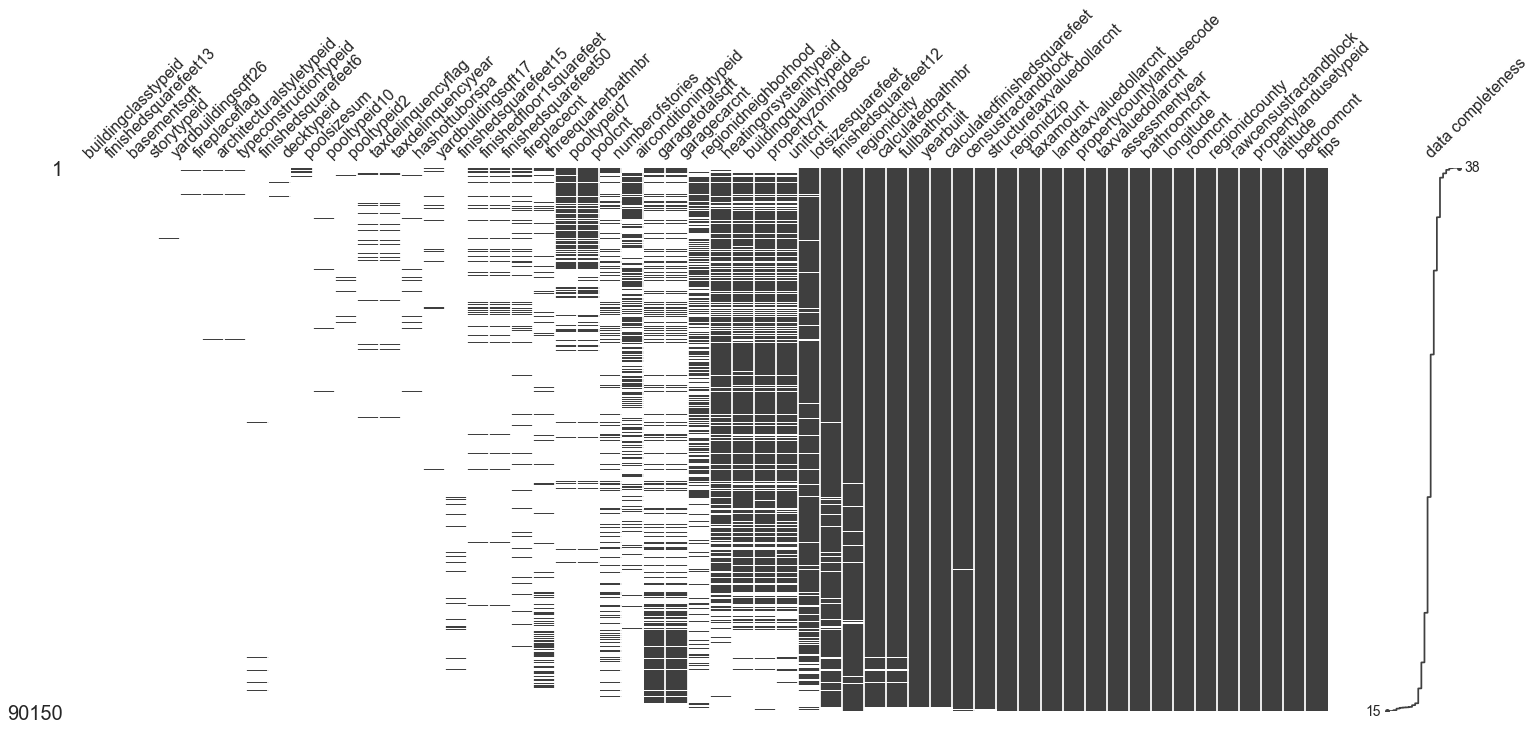

In [61]:
colnames = properties_in_train.count().sort_values().index
msno.matrix(msno.nullity_sort(properties_in_train[colnames], sort='descending'), 
            labels=True)

## Preprocessing data

In [296]:
drop_cols = [
    'fips', # fips is identical to regionidcounty
    'censustractandblock', # identical to rawcensustractandblock
#    'propertyzoningdesc',
#    'rawcensustractandblock',
#    'regionidcity',
#    'regionidneighborhood',
#    'regionidzip',
    'assessmentyear', # same year
    'taxdelinquencyyear', # represented by tax delinquency year
#    'buildingclasstypeid',
    'finishedsquarefeet13',
    'basementsqft',
#    'storytypeid',
#    'yardbuildingsqft26',
    'fireplaceflag',
    'finishedsquarefeet6',
    'finishedfloor1squarefeet',
    'finishedsquarefeet50',
    'finishedsquarefeet12',
    'finishedsquarefeet15',
    'calculatedbathnbr',
    'fullbathcnt',
    'calculatedbathnbr',
    'threequarterbathnbr',
    'yardbuildingsqft26',
    'yardbuildingsqft17',
    'landtaxvaluedollarcnt',
    'structuretaxvaluedollarcnt',
    'pooltypeid10',
    'pooltypeid7',
    'pooltypeid2',
    'poolcnt',
    'fireplacecnt',
    'garagecarcnt',
    'bedroomcnt',
    'buildingclasstypeid',
    'storytypeid',
    'architecturalstyletypeid',
    'typeconstructiontypeid',
    'decktypeid'
]

string_categorical_cols = [
    'hashottuborspa'
    ,'propertycountylandusecode'
    ,'taxdelinquencyflag'
    ,'propertyzoningdesc'
    
]


In [288]:
for table in tables:
    table['fullbathcnt'].fillna(0, inplace=True)
    table['threequarterbathnbr'].fillna(0, inplace=True)
    table['yardbuildingsqft17'].fillna(0, inplace=True)
    table['yardbuildingsqft26'].fillna(0, inplace=True)
    table['unitcnt'].fillna(0, inplace=True)
    table['taxdelinquencyflag'].fillna('N', inplace=True)
    table['poolcnt'].fillna(0, inplace=True)
    table['fireplacecnt'].fillna(0, inplace=True)
    table['garagecarcnt'].fillna(0, inplace=True)
    table['bedroomcnt'].fillna(0, inplace=True)
    table['pooltypeid10'].fillna(0, inplace=True)
    table['pooltypeid7'].fillna(0, inplace=True)
    table['pooltypeid2'].fillna(0, inplace=True)
    table['poolsizesum'].fillna(0, inplace=True)
    table['hashottuborspa'].fillna('False', inplace=True)
    table['yearbuilt'].fillna(0, inplace=True)
    
    table['bathroomcnt'] = table['fullbathcnt']+table['threequarterbathnbr']*.5
    table['yardbuildingsqft'] = table['yardbuildingsqft17']+table['yardbuildingsqft26']
    table['roomcnt'] = table['poolcnt']*2 + \
    table['fireplacecnt']*.5 + \
    table['garagecarcnt']*1 + \
    table['bedroomcnt']*2
    table['pooltypeid'] = table['pooltypeid10']*10 + \
    table['pooltypeid7']*7 + \
    table['pooltypeid2']*2



In [289]:
# Drop Columns
for table in tables:
    for col in properties_in_train.columns:
    # drop columns
        if col in drop_cols:
            print('Dropping {}...'.format(col))
            table.drop(col, axis=1, inplace=True)
print('done!') 

Dropping architecturalstyletypeid...
Dropping basementsqft...
Dropping bedroomcnt...
Dropping buildingclasstypeid...
Dropping calculatedbathnbr...
Dropping decktypeid...
Dropping finishedfloor1squarefeet...
Dropping finishedsquarefeet12...
Dropping finishedsquarefeet13...
Dropping finishedsquarefeet15...
Dropping finishedsquarefeet50...
Dropping finishedsquarefeet6...
Dropping fips...
Dropping fireplacecnt...
Dropping fullbathcnt...
Dropping garagecarcnt...
Dropping poolcnt...
Dropping pooltypeid10...
Dropping pooltypeid2...
Dropping pooltypeid7...
Dropping storytypeid...
Dropping threequarterbathnbr...
Dropping typeconstructiontypeid...
Dropping yardbuildingsqft17...
Dropping yardbuildingsqft26...
Dropping fireplaceflag...
Dropping structuretaxvaluedollarcnt...
Dropping assessmentyear...
Dropping landtaxvaluedollarcnt...
Dropping taxdelinquencyyear...
Dropping censustractandblock...
done!


In [290]:
# categorical columns
numerical_categorical_cols = [x for x in properties_in_train.columns if re.search('id$', x)]
print(categorical_cols)

categorical_cols = string_categorical_cols + numerical_categorical_cols

['hashottuborspa', 'propertycountylandusecode', 'fireplaceflag', 'airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'buildingqualitytypeid', 'decktypeid', 'heatingorsystemtypeid', 'propertylandusetypeid', 'storytypeid', 'typeconstructiontypeid']


In [212]:
properties_in_train['fireplaceflag'].value_counts(dropna=False)

1    89930
0      220
Name: fireplaceflag, dtype: int64

In [297]:
from sklearn import preprocessing

for col_name in string_categorical_cols:
    print('preprocessing {}...'.format(col_name))
    # create a LabelEncoder instance
    encoder = preprocessing.LabelEncoder()
    # fit LabelEncoder
    if include_properties:
        encoder.fit(properties[col_name].astype(str))
    else:
        encoder.fit(properties_in_train[col_name].astype(str))
    # transform training set & test set based on training set
    properties_in_train[col_name] = encoder.transform(properties_in_train[col_name].astype(str))
    if include_properties:
        properties[col_name] = encoder.transform(properties[col_name].astype(str))
print('done!') 

preprocessing hashottuborspa...
preprocessing propertycountylandusecode...
preprocessing taxdelinquencyflag...
preprocessing propertyzoningdesc...
done!


In [292]:
def categoryFilter(fit_data, transform_data=[], cols=[], fillna=None):
    for t_data in transform_data:
        for col in cols:
            levels = fit_data.loc[~fit_data[col].isnull(), col].unique()
            t_data.loc[~t_data[col].isin(levels), col] = np.nan
            t_data[col] = t_data[col]
        if fillna is not None:
            t_data = t_data.fillna(fillna)
        yield t_data

In [293]:
for col in properties_in_train.columns:
    print('preprocessing {}...'.format(col))
    # fix categorical levels
    if col in categorical_cols:
        if include_properties:
            properties_in_train, properties = categoryFilter(
                fit_data=properties_in_train, 
                transform_data=[properties_in_train,properties], 
                cols=[col], 
                fillna=-1
            )
print('done!') 
#drop the column is the drop list
#fix the discrepencies of levels in training and testing datasets

preprocessing airconditioningtypeid...
preprocessing bathroomcnt...
preprocessing buildingqualitytypeid...
preprocessing calculatedfinishedsquarefeet...
preprocessing garagetotalsqft...
preprocessing hashottuborspa...
preprocessing heatingorsystemtypeid...
preprocessing latitude...
preprocessing longitude...
preprocessing lotsizesquarefeet...
preprocessing poolsizesum...
preprocessing propertycountylandusecode...
preprocessing propertylandusetypeid...
preprocessing propertyzoningdesc...
preprocessing rawcensustractandblock...
preprocessing regionidcity...
preprocessing regionidcounty...
preprocessing regionidneighborhood...
preprocessing regionidzip...
preprocessing roomcnt...
preprocessing unitcnt...
preprocessing yearbuilt...
preprocessing numberofstories...
preprocessing taxvaluedollarcnt...
preprocessing taxamount...
preprocessing taxdelinquencyflag...
preprocessing yardbuildingsqft...
preprocessing pooltypeid...
done!


In [294]:
# imp = DataFrameImputer()

# imp.fit(properties_in_train)
# properties_in_train = imp.transform(properties_in_train)
# properties = imp.transform(properties)

# impute na with -1 for numeric positive values
properties_in_train.fillna(-1, inplace=True)
if include_properties:
    properties.fillna(-1, inplace=True)

In [298]:
properties_in_train.dtypes

airconditioningtypeid           float64
bathroomcnt                     float64
buildingqualitytypeid           float64
calculatedfinishedsquarefeet    float64
garagetotalsqft                 float64
hashottuborspa                    int64
heatingorsystemtypeid           float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
poolsizesum                     float64
propertycountylandusecode         int64
propertylandusetypeid           float64
propertyzoningdesc                int64
rawcensustractandblock          float64
regionidcity                    float64
regionidcounty                  float64
regionidneighborhood            float64
regionidzip                     float64
roomcnt                         float64
unitcnt                         float64
yearbuilt                       float64
numberofstories                 float64
taxvaluedollarcnt               float64
taxamount                       float64


## Data Preparation

In [299]:
train_set = pd.merge(
    properties_in_train.dropna(axis=1), 
    train, 
    left_index = True, 
    right_on='parcelid'
)
train_set['month'] = pd.to_datetime(train_set['transactiondate']).dt.month
train_set = train_set.drop('parcelid', axis=1).drop('transactiondate', axis=1)

In [300]:
X = train_set.drop('logerror', axis=1)
y = train_set['logerror']

In [301]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=0)

## Cross Validation

### [RandomForestRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

In [302]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[5,10,20],'n_jobs':[-1],'oob_score':[False]}

rf_reg = RandomForestRegressor(verbose=1)
rf_cv = GridSearchCV(rf_reg,
                     param_grid=parameters,
                     scoring='neg_mean_absolute_error',
                     cv=3)  
rf_cv.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_job

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=1, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 20], 'n_jobs': [-1], 'oob_score': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [303]:
# best cv parameters
print(rf_cv.best_params_)

{'n_estimators': 20, 'n_jobs': -1, 'oob_score': False}


In [304]:
def feature_importance(estimator, labels):
    feature_imp = pd.DataFrame.from_dict({'feature':labels,
                                          'importance':estimator.feature_importances_})
    feature_imp.set_index('feature',
                          inplace=True, 
                          drop=True)
    feature_imp = feature_imp.sort_values('importance', ascending=False)
    feature_imp.plot.bar()

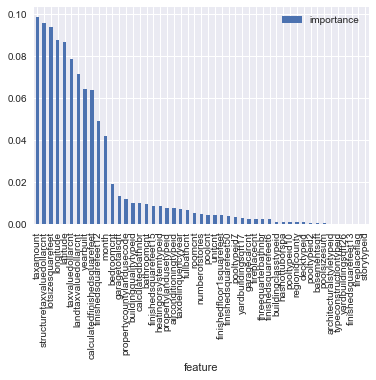

In [223]:
feature_importance(rf_cv.best_estimator_, X_train.columns)

In [305]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, rf_cv.best_estimator_.predict(X_test))

[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.2s finished


0.077428253006117595

#### GradientBoostingRegressor

In [306]:
from sklearn.ensemble import GradientBoostingRegressor

parameters = {'n_estimators':[5, 10, 20],
              'learning_rate':[0.01, 0.1],
              'max_depth':[1,3,5]
             }

gb_reg = GradientBoostingRegressor(verbose=1)

gb_cv = GridSearchCV(gb_reg,
                     param_grid=parameters,
                     scoring='neg_mean_absolute_error',
                     cv=3)  
gb_cv.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.0260            0.07s
         2           0.0260            0.05s
         3           0.0260            0.03s
         4           0.0260            0.02s
         5           0.0260            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0254            0.08s
         2           0.0254            0.06s
         3           0.0254            0.04s
         4           0.0254            0.02s
         5           0.0254            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0257            0.11s
         2           0.0257            0.07s
         3           0.0257            0.04s
         4           0.0257            0.02s
         5           0.0257            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0260            0.19s
         2           0.0260            0.15s
         3           0.0260            0.13s
      

         3           0.0253            0.29s
         4           0.0253            0.15s
         5           0.0253            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0257            0.90s
         2           0.0257            0.58s
         3           0.0257            0.40s
         4           0.0256            0.20s
         5           0.0256            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0260            1.66s
         2           0.0260            1.28s
         3           0.0260            1.12s
         4           0.0259            1.01s
         5           0.0259            0.88s
         6           0.0259            0.70s
         7           0.0259            0.52s
         8           0.0259            0.34s
         9           0.0259            0.17s
        10           0.0259            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0254            1.31s
       

      Iter       Train Loss   Remaining Time 
         1           0.0259            0.81s
         2           0.0259            0.73s
         3           0.0258            0.64s
         4           0.0258            0.55s
         5           0.0257            0.46s
         6           0.0257            0.37s
         7           0.0257            0.28s
         8           0.0256            0.18s
         9           0.0256            0.09s
        10           0.0256            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0253            0.63s
         2           0.0252            0.58s
         3           0.0252            0.53s
         4           0.0251            0.45s
         5           0.0251            0.38s
         6           0.0250            0.31s
         7           0.0250            0.23s
         8           0.0249            0.16s
         9           0.0249            0.08s
        10           0.0248            0.00s
      It

GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=1,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 20], 'learning_rate': [0.01, 0.1], 'max_depth': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [307]:
print(gb_cv.best_params_)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 5}


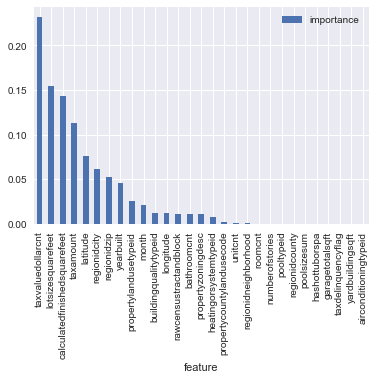

In [308]:
feature_importance(gb_cv.best_estimator_, X_train.columns)

In [309]:
mean_absolute_error(y_test, gb_cv.best_estimator_.predict(X_test))

0.067493329273472222

## Final model fit

In [37]:
gb_final = GradientBoostingRegressor(**gb_cv.best_params_)

In [38]:
gb_final.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=5, presort='auto',
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

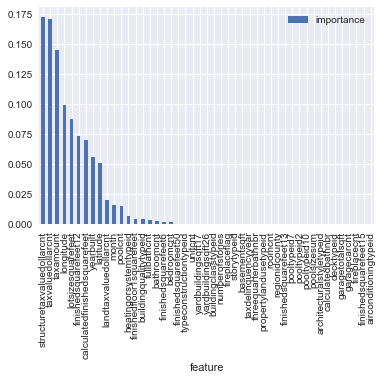

In [39]:
feature_importance(gb_final, X.columns)

In [67]:
test_set = properties
test_set['month'] = 11

test_pred = gb_final.predict(test_set)

In [68]:
prediction = pd.DataFrame.from_dict({'index':test_set.index,
                                     'predict':test_pred})
prediction.set_index('index')

,predict
index,
10754147,0.877758
10759547,0.016404
10843547,0.004060
10859147,0.009801
10879947,0.009801
10898347,0.009801
10933547,0.009801
10940747,0.009801
10954547,0.877758


In [70]:
prediction.columns=['ParcelId','201610']
prediction['201611']=prediction['201610']
prediction['201612']=prediction['201610']
prediction['201710']=0
prediction['201711']=0
prediction['201712']=0

In [72]:
prediction=prediction.round(4)

In [75]:
from pandas import ExcelWriter

# DF TO CSV
prediction.to_csv('PythonExport_round.csv', sep=',',index=False)

In [74]:
prediction.shape

(2985217, 7)